# Method of Simulated Moments (MSM) for Structural Estimation

### Steps of MSM estimation
1. Load empirical data
2. Define a function to calculate empirical moments from the data
3. Calculate the covariance matrix of the empirical moments (for the weighting matrix)
4. Define a `HARK` agent type with the model parameters to be estimated
5. Define a function to simulate the model and calculate the simulated moments
6. Estimate the model parameters by minimizing the distance between the empirical and simulated moments

In [10]:
from __future__ import annotations

import warnings

import numpy as np
import pandas as pd
from statsmodels.stats.weightstats import DescrStatsW

warnings.simplefilter(action="ignore", category=FutureWarning)

## 1. Load empirical data

In [11]:
scf_data = pd.read_stata("../data/scf_processed.dta")

scf_data = scf_data.replace([np.inf, -np.inf], np.nan)
scf_data = scf_data.dropna()

scf_data["networththou"] = scf_data["networth"] / 1000
scf_data["finthou"] = scf_data["fin"] / 1000

## 2. Calculate Moments

In [12]:
indices = scf_data["age_lbl"].unique().sort_values()
indices

['(21-25]', '(26-30]', '(31-35]', '(36-40]', '(41-45]', ..., '(71-75]', '(76-80]', '(81-85]', '(86-90]', '(91-95]']
Length: 15
Categories (15, object): ['(21-25]' < '(26-30]' < '(31-35]' < '(36-40]' ... '(76-80]' < '(81-85]' < '(86-90]' < '(91-95]']

In [13]:
def calculate_weighted_median(data):
    stats = DescrStatsW(data["finthou"], weights=data["wgt"])
    return stats.quantile(0.5, return_pandas=False)[0]


def calculate_moments(data):
    medians = data.groupby(["age_lbl"]).apply(
        calculate_weighted_median,
        include_groups=False,
    )
    return medians.reindex(indices, fill_value=0.0)

In [14]:
empirical_moments = calculate_moments(scf_data)
empirical_moments

age_lbl
(21-25]     3.920167
(26-30]    10.731806
(31-35]    19.474649
(36-40]    26.711670
(41-45]    38.846864
(46-50]    58.384827
(51-55]    66.187000
(56-60]    82.265840
(61-65]    76.000000
(66-70]    84.800000
(71-75]    77.500000
(76-80]    54.837487
(81-85]    68.688031
(86-90]    62.365245
(91-95]    60.545638
dtype: float64

<Axes: xlabel='age_lbl'>

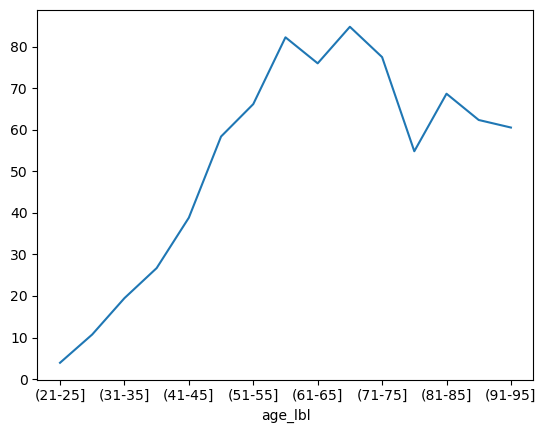

In [15]:
empirical_moments.plot()

## 3. Calculate the covariance matrix of empirical moments

In [16]:
# moments_cov = em.get_moments_cov(
#     scf_data,
#     calculate_moments,
#     bootstrap_kwargs={
#         "seed": 11323,
#         "n_cores": 12,
#         "error_handling": "continue",
#     },
# )

# moments_cov.to_pickle("finassets_cov.pkl")

moments_cov = pd.read_pickle("finassets_cov.pkl")

moments_cov

age_lbl,(21-25],(26-30],(31-35],(36-40],(41-45],(46-50],(51-55],(56-60],(61-65],(66-70],(71-75],(76-80],(81-85],(86-90],(91-95]
age_lbl,,,,,,,,,,,,,,,
(21-25],0.016801,-0.000749,-0.002685,0.002035,0.004864,0.003656,0.000328,0.014750,-0.002181,-0.007886,0.008624,0.003455,-0.003829,0.013656,-0.025521
(26-30],-0.000749,0.039618,-0.002933,0.009414,0.003510,0.002786,-0.008376,0.004830,0.007423,0.012024,0.031356,0.006701,0.015580,0.021508,-0.011097
(31-35],-0.002685,-0.002933,0.163474,0.010342,-0.001325,0.027629,0.015236,0.014758,0.043892,0.035808,-0.019665,0.015921,-0.024180,0.017549,0.106535
(36-40],0.002035,0.009414,0.010342,0.456068,0.033588,0.067388,0.012491,0.010992,0.035021,-0.094145,0.030651,0.011621,-0.051711,0.010470,0.080925
(41-45],0.004864,0.003510,-0.001325,0.033588,1.034562,-0.090549,0.170603,-0.015446,-0.045916,0.011664,0.170984,-0.039976,-0.157313,0.009196,-0.008536
(46-50],0.003656,0.002786,0.027629,0.067388,-0.090549,3.038064,-0.052855,0.310041,-0.003971,0.088649,-0.124644,0.129644,-0.110991,-0.129766,0.675545
(51-55],0.000328,-0.008376,0.015236,0.012491,0.170603,-0.052855,5.028821,0.282000,0.367655,-0.379126,-0.045354,-0.216652,0.033490,0.805542,-0.104134
(56-60],0.014750,0.004830,0.014758,0.010992,-0.015446,0.310041,0.282000,6.389591,-0.060930,0.353854,-0.243218,0.053496,-0.107208,-0.010087,0.457610
(61-65],-0.002181,0.007423,0.043892,0.035021,-0.045916,-0.003971,0.367655,-0.060930,7.981681,-0.130882,-0.410915,-0.106258,-0.196294,0.000222,1.271103


In [17]:
pd.Series(np.sqrt(np.diag(moments_cov)), index=indices)

(21-25]    0.129620
(26-30]    0.199043
(31-35]    0.404319
(36-40]    0.675328
(41-45]    1.017134
(46-50]    1.743004
(51-55]    2.242503
(56-60]    2.527764
(61-65]    2.825187
(66-70]    2.946045
(71-75]    3.282611
(76-80]    2.044789
(81-85]    3.281060
(86-90]    4.191847
(91-95]    6.308777
dtype: float64